
<img src="https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10 (демо)
## <center> Прогнозирование задержек вылетов

Ваша задача – побить единственный бенчмарк в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен этот бенчмарк. Конечно, с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит Xgboost. Но проверьте еще Catboost.

<img src="https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/img/xgboost_meme.jpg" width=40% />

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

In [ ]:
!pip install -q catboost optuna optuna-integration dython lime shap

In [ ]:
import numpy as np
import pandas as pd

from collections import Counter

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna.integration import OptunaSearchCV
from dython.nominal import associations

import shap
import lime

In [ ]:
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
sns.set_style('dark')

In [ ]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

In [ ]:
train = train.rename(columns={'DayofMonth': 'DayOfMonth'})
test = test.rename(columns={'DayofMonth': 'DayOfMonth'})

In [ ]:
train.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [ ]:
test.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0   c-7       c-25       c-3      615            YV    MRY  PHX       598
1   c-4       c-17       c-2      739            WN    LAS  HOU      1235
2  c-12        c-2       c-7      651            MQ    GSP  ORD       577
3   c-3       c-25       c-7     1614            WN    BWI  MHT       377
4   c-6        c-6       c-3     1505            UA    ORD  STL       258

### Анализ данных

Проверим, нет ли в данных отсутствующих значений

In [ ]:
print(f'В тренировочных данных количество пропусков: {train.isna().sum().sum()}')
print(f'В тестовых данных количество пропусков: {test.isna().sum().sum()}')

В тренировочных данных количество пропусков: 0
В тестовых данных количество пропусков: 0


Отлично, их нет

Посмотрим на дизбаланс классов

In [ ]:
train['dep_delayed_15min'].value_counts()

dep_delayed_15min
N    80956
Y    19044
Name: count, dtype: int64

Как видно, данные сильно дизбалансированы (объектов 0 класса более чем в 4 раза больше, чем 1). Это надо будет учесть при обучении моделей

Посмотрим на признак времени вылета

In [ ]:
train['DepTime'].value_counts().sort_index()

DepTime
1        7
2        9
3        4
4        4
5       11
        ..
2505     1
2514     1
2522     1
2530     1
2534     1
Name: count, Length: 1300, dtype: int64

Замечаем, что есть значения, большие, чем 2359, что является ошибкой, так как в сутках только 24 часа, далее посмотрим, сколько таких записей вообще есть в тренировочных данных

In [ ]:
train[train['DepTime'] > 2359].shape[0]

29

Сделаем следующее - возьмём остаток времени вылета от 2400, таким образом все значения будут от 0 до 2359. Проделаем это также и с тестовой выборкой

In [ ]:
train['DepTime'] = train['DepTime'] % 2400
test['DepTime'] = test['DepTime'] % 2400

Добавим в тренировочные данные числовые признаки месяца, дня месяца и дня недели (для удобства визуализации)

In [ ]:
train.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [ ]:
train = train.assign(
    NumberMonth=train['Month'].str[2:].astype(int),
    NumberDayOfMonth=train['DayOfMonth'].str[2:].astype(int),
    NumberDayOfWeek=train['DayOfWeek'].str[2:].astype(int)
)

In [ ]:
def plot_histograms(
    column, plotbars=True, figsize=(15, 8), hue_order=['N', 'Y'],
    countpalette=['blue', 'orange'], barpalette='magma', fontsize=10,
    rotation=0, fmt='%.3f'
):
    _, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    sns.countplot(
        data=train.sort_values(by=column), x=column,
        hue='dep_delayed_15min', hue_order=hue_order,
        palette=countpalette, ax=axes[0]
    )
    if plotbars:
        for container in axes[0].containers:
            axes[0].bar_label(container, rotation=rotation, fontsize=fontsize)
    axes[0].set_title('Количество задержанных и незадержанных рейсов')
    sns.move_legend(axes[0], 'upper left', bbox_to_anchor=(1, 1))

    sns.barplot(
        (
            train[train['dep_delayed_15min'] == 'Y'][column].value_counts() /
            train[column].value_counts()
        ).sort_index(), palette=barpalette, ax=axes[1]
    )
    if plotbars:
        for container in axes[1].containers:
            axes[1].bar_label(container, fmt=fmt)
    axes[1].set_title('Процент задержанных рейсов')

    plt.tight_layout()
    plt.show()

Исследуем гистограммы числа месяца

<ipython-input-17-183c3922b600>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


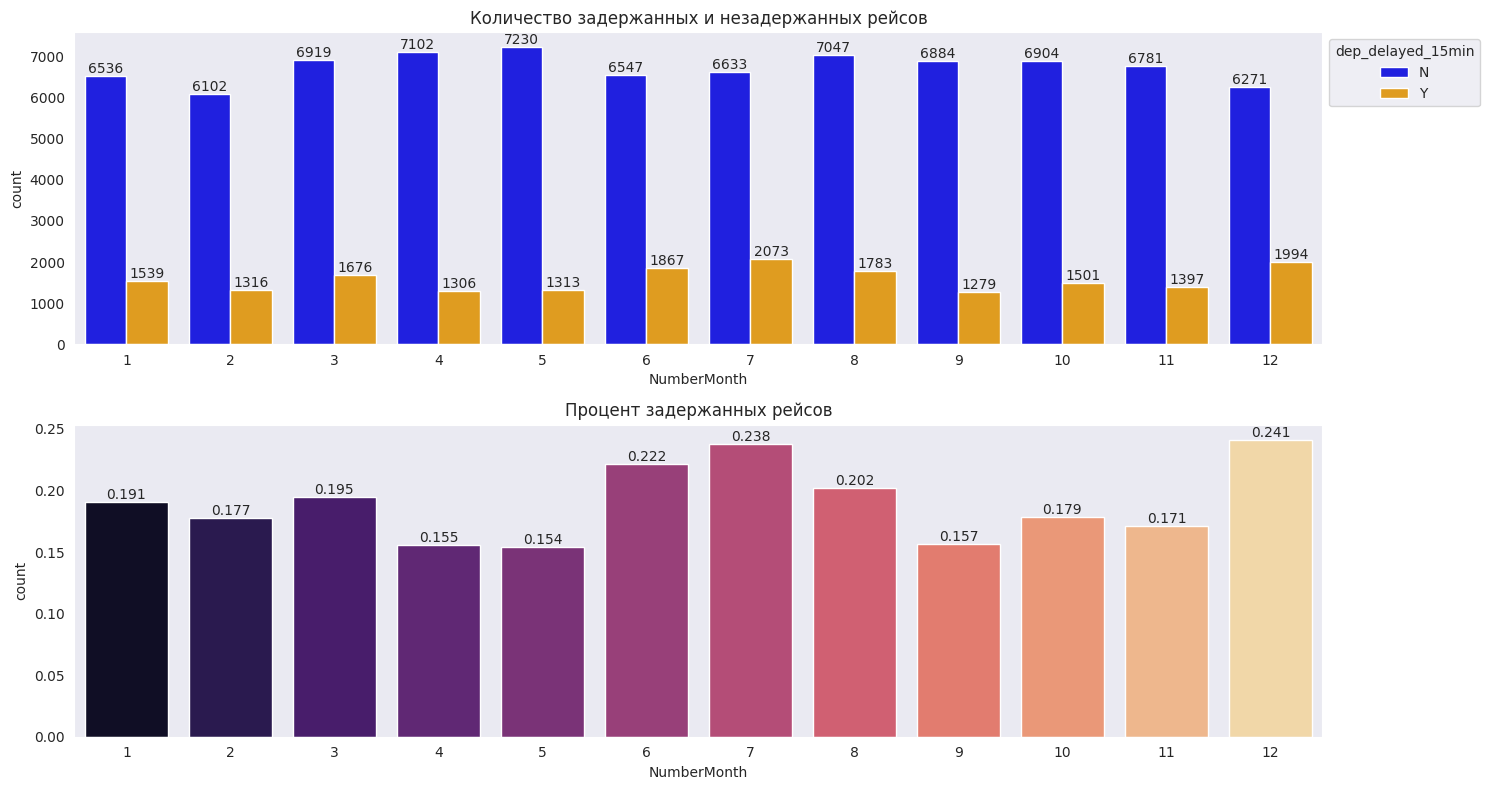

In [ ]:
plot_histograms('NumberMonth')

Видим, что в каждом месте количество незадержанных рейсов кратно превышает число задержанных. Однако важно учитывать не только количество, но и процентное содержание задержанных рейсов. Например, самое большое их количество в июле (2073), но процентное содержание больше всего в декабре (~0.2413)

В целом, это важный признак для будущих моделей, поэтому его следует оставить

Теперь рассмотрим гистограммы для признака дня недели

<ipython-input-17-183c3922b600>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


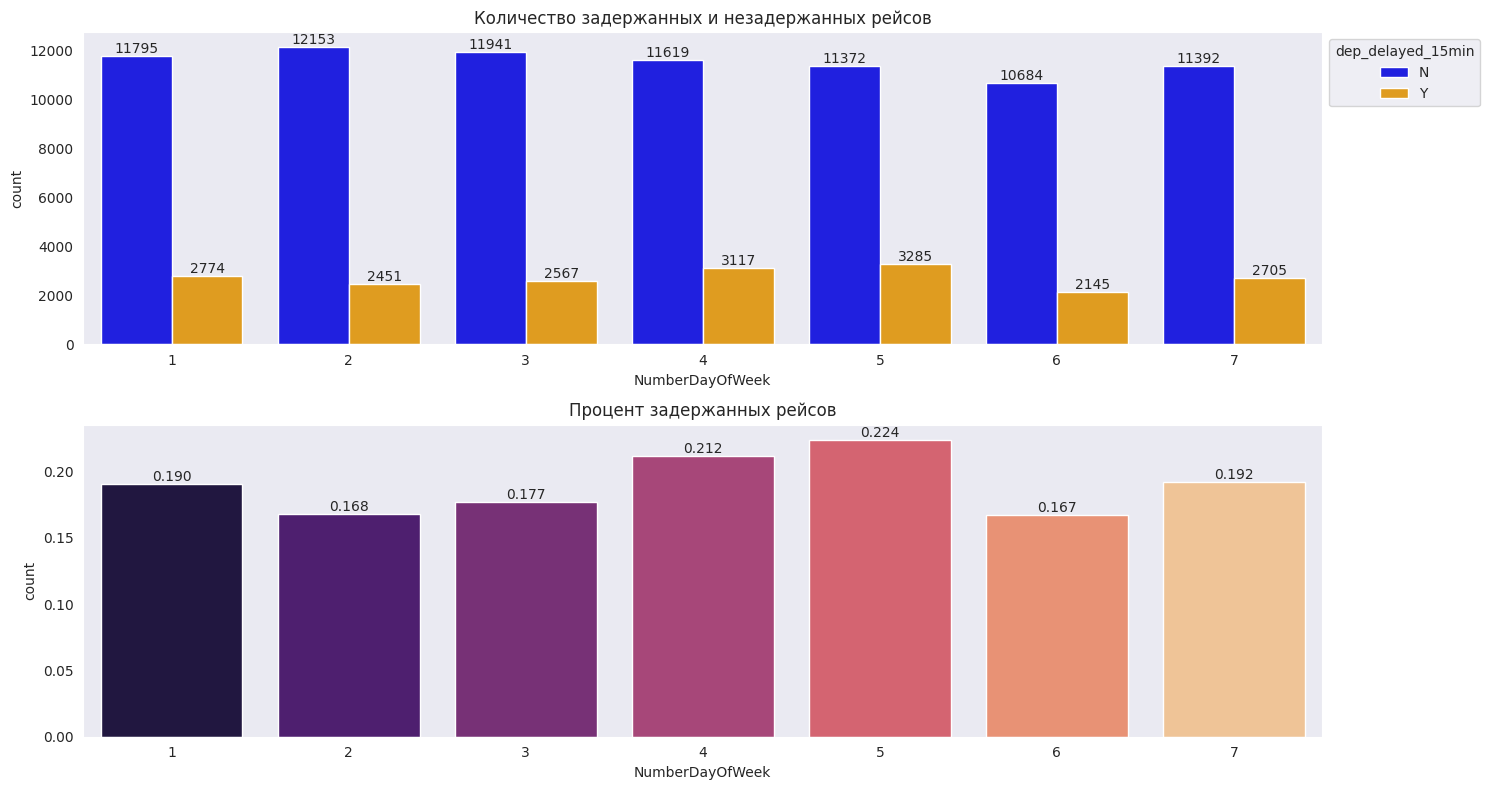

In [ ]:
plot_histograms('NumberDayOfWeek')

А у признака дня недели большее количество неотменённых рейсов почти всегда соотвествует большему их процентному содержанию (исключение составляет лишь случай понедельника и воскресенья), и этот признак следует сохранить, так как возможно на тестовой выборке будет наблюдаться та же самая зависимость

 Теперь пронаблюдаем гистограммы для дня месяца

<ipython-input-17-183c3922b600>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


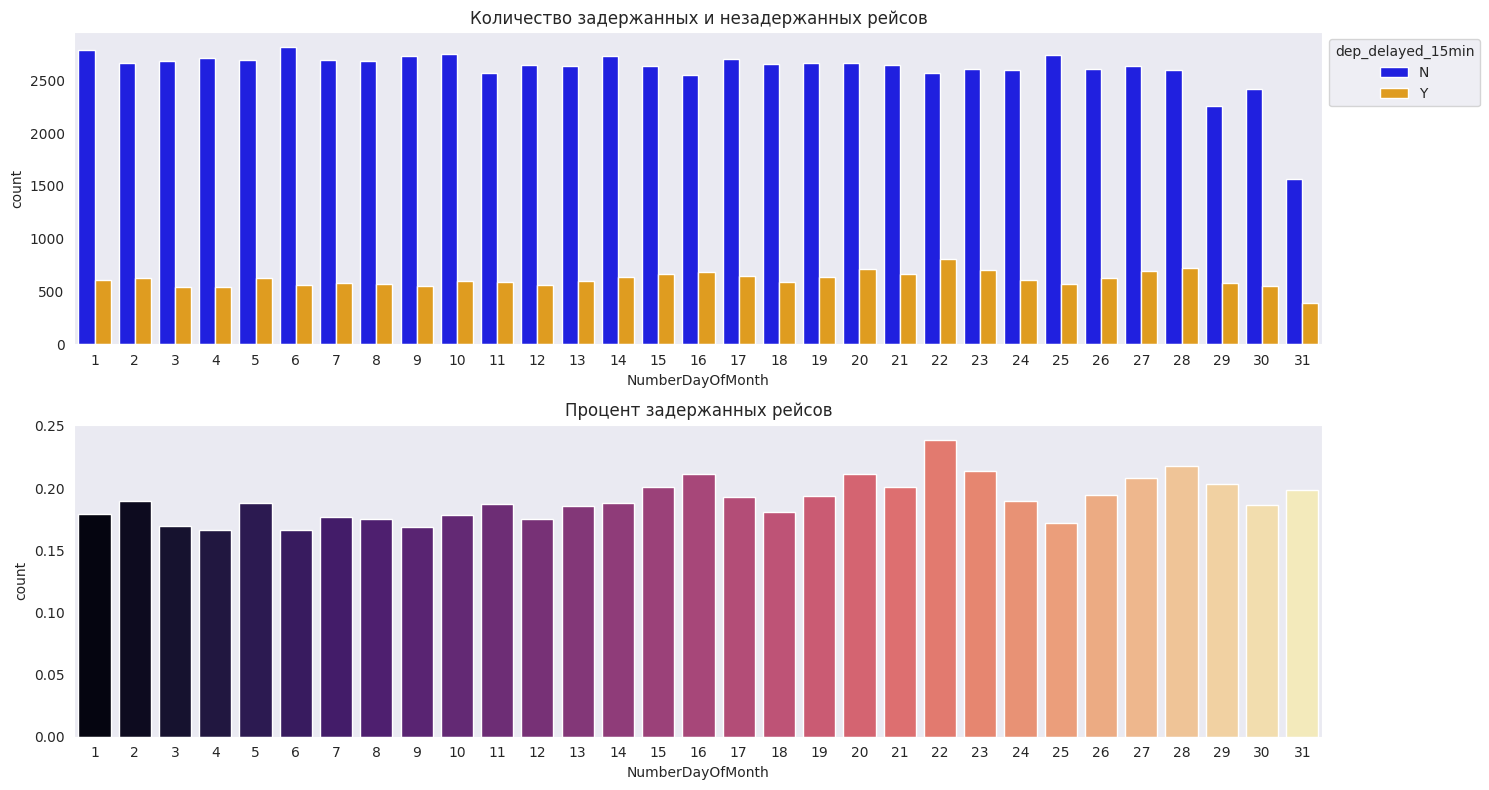

In [ ]:
plot_histograms('NumberDayOfMonth', plotbars=False)

Видим, что числам с 29 по 31 соответсвуют меньшие значения числа задержанных рейсов, но в процентном содержании они не являются экстремальными значениями. Также замечаем, что в процентном и количественном отношении больше всего рейсов было задержано 22 числа

Добавим эти же признаки в тестовую выборку

In [ ]:
train = train.drop(columns=['NumberMonth', 'NumberDayOfWeek', 'NumberDayOfMonth'])

In [ ]:
test.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0   c-7       c-25       c-3      615            YV    MRY  PHX       598
1   c-4       c-17       c-2      739            WN    LAS  HOU      1235
2  c-12        c-2       c-7      651            MQ    GSP  ORD       577
3   c-3       c-25       c-7     1614            WN    BWI  MHT       377
4   c-6        c-6       c-3     1505            UA    ORD  STL       258

Затем посмотрим на гистограммы компании-перевозчика

<ipython-input-17-183c3922b600>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


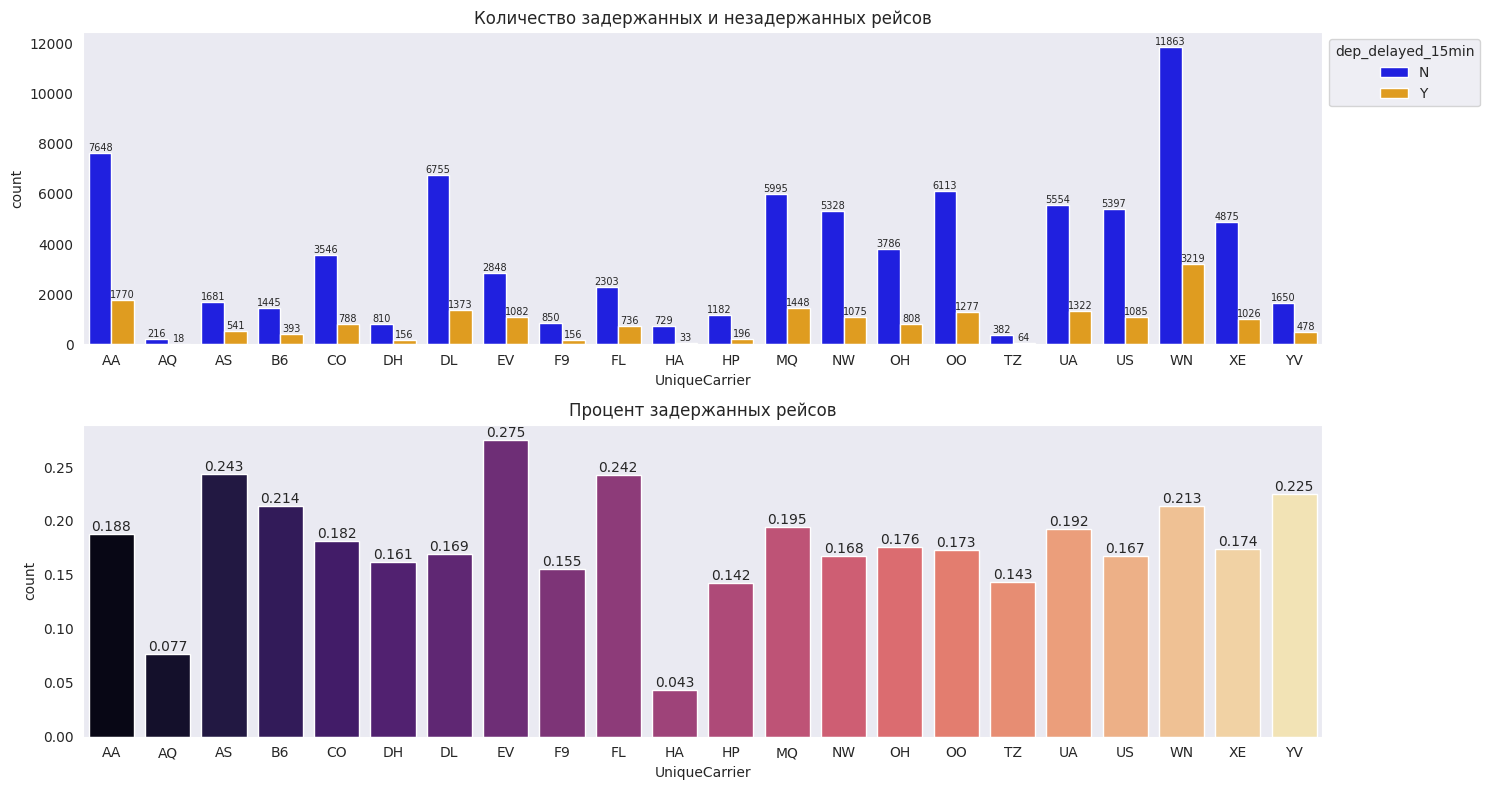

In [ ]:
plot_histograms('UniqueCarrier', fontsize=7)

А вот тут видно, заметен большой разброс как среди количественных, так и среди процентных значений. По количественному показателю худшей является авиакомпания WN, а по процентному - EV. Признак авиаперевозчика является очень важным для предсказани задержания рейса, поэтому его непременно следует оставить

Создадим ещё один признак - так как пунктов назначения и отправки достаточно много, то мы разделим их на неколько категорий по количеству отправленных/принятых рейсов. Причём границы категорий будут равномерно распределны в логарифмическом масштабе

In [ ]:
def get_airports(column, categories):
    train_flights, test_flights = pd.DataFrame(train[column].value_counts()), pd.DataFrame(test[column].value_counts())
    train_values, test_values = [], []
    borders = np.concatenate([np.array([0]), np.logspace(1, np.log10(6000), categories)])

    for i in range(1, borders.shape[0]):
        train_values.append(train_flights[(train_flights['count'] > borders[i - 1]) & (train_flights['count'] <= borders[i])].index)
        test_values.append(test_flights[(test_flights['count'] > borders[i - 1]) & (test_flights['count'] <= borders[i])].index)

    train_sizes = [value.shape[0] for value in train_values]
    test_sizes = [value.shape[0] for value in test_values]

    ax = sns.barplot(data=pd.DataFrame({
        'index': list(range(0, categories)) + list(range(0, categories)),
        'size': train_sizes + test_sizes,
        'label': ['train'] * categories + ['test'] * categories
    }), x='index', y='size', hue='label')

    ax.set_xlabel(column)
    for container in ax.containers:
        ax.bar_label(container)

    ax.set_ylabel('Airports')

    return train_values, test_values

Визуальным эмпирическим путём было выяснено, что лучше всего распределения нового признака на тренировочной и тестовой выборке совпадают, когда общее число категорий равняется 6

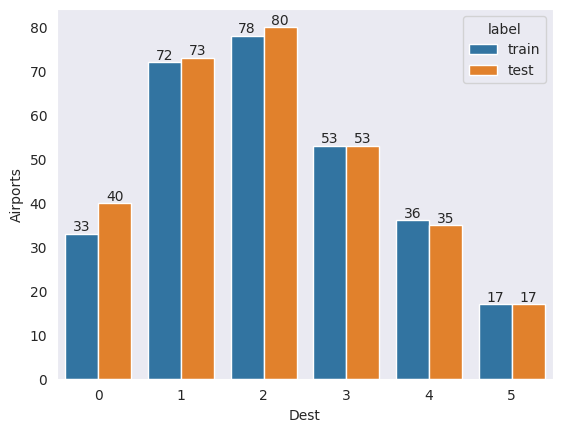

In [ ]:
train_dests, test_dests = get_airports('Dest', 6)

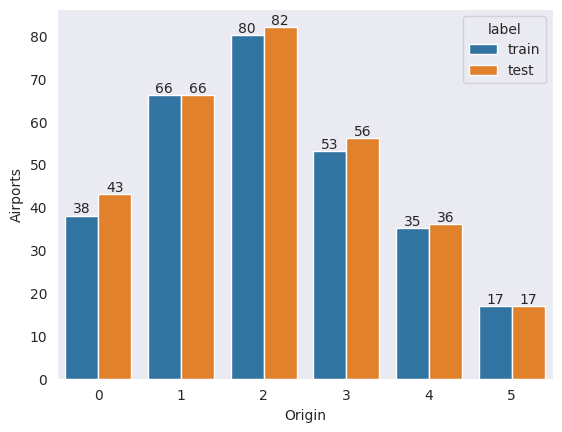

In [ ]:
train_origins, test_origins = get_airports('Origin', 6)

Этот признак можно сделать численным (как будто он был обработан label-encoder-ом), так как чем больше значение, тем большее число рейсов отправляет/принимает данный аэропорт

In [ ]:
def insert_and_full(df, column, values):
    df.insert(loc=df.columns.get_loc(column) + 1, column=column + 'Cat', value=0)
    for index in range(len(values)):
        df.loc[df[column].isin(values[index]), column + 'Cat'] = index
    return df

In [ ]:
train = insert_and_full(train, 'Origin', train_origins)
train = insert_and_full(train, 'Dest', train_dests)
test = insert_and_full(test, 'Origin', test_origins)
test = insert_and_full(test, 'Dest', test_dests)

In [ ]:
train.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-8       c-21       c-7     1934            AA    ATL          5  DFW   
1   c-4       c-20       c-3     1548            US    PIT          4  MCO   
2   c-9        c-2       c-5     1422            XE    RDU          4  CLE   
3  c-11       c-25       c-6     1015            OO    DEN          5  MEM   
4  c-10        c-7       c-6     1828            WN    MDW          4  OMA   

   DestCat  Distance dep_delayed_15min  
0        5       732                 N  
1        5       834                 N  
2        4       416                 N  
3        4       872                 N  
4        3       423                 Y

In [ ]:
test.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-7       c-25       c-3      615            YV    MRY          2  PHX   
1   c-4       c-17       c-2      739            WN    LAS          5  HOU   
2  c-12        c-2       c-7      651            MQ    GSP          3  ORD   
3   c-3       c-25       c-7     1614            WN    BWI          4  MHT   
4   c-6        c-6       c-3     1505            UA    ORD          5  STL   

   DestCat  Distance  
0        5       598  
1        4      1235  
2        5       577  
3        3       377  
4        4       258

Теперь посмотрим на плотноти распределения время вылета и расстояния в зависимотси от того, был задержан рейс или нет

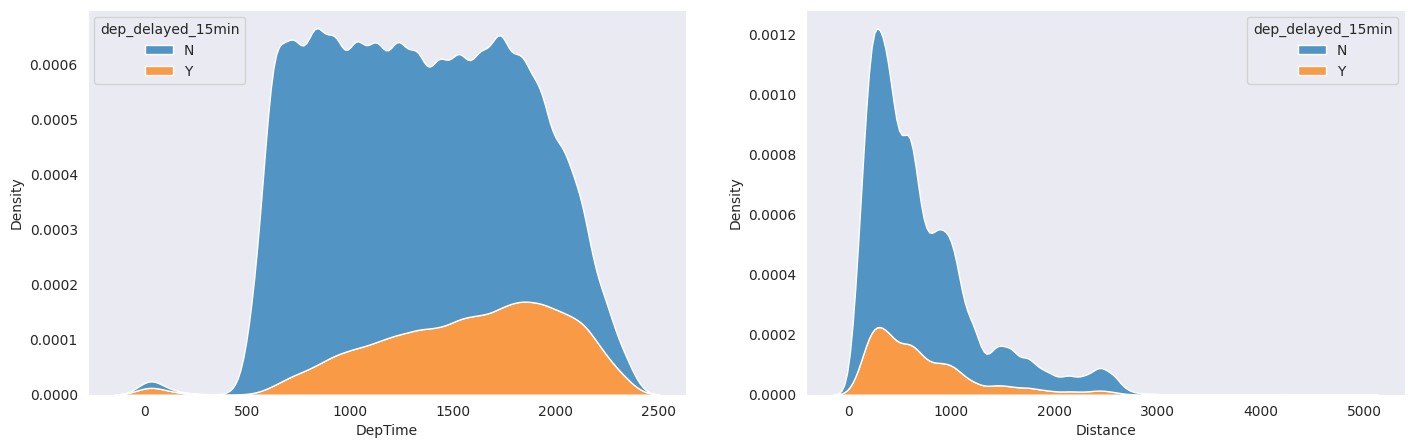

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
sns.kdeplot(data=train, x='DepTime', hue='dep_delayed_15min', multiple='stack', ax=ax[0])
sns.kdeplot(data=train, x='Distance', hue='dep_delayed_15min', multiple='stack', ax=ax[1])
plt.show()

Замечаем, что если у признака дистанции оба распределения смахивают на экспоненциальное, хоть и довольно сильно раличаются по форме, то вот у признака времени вылета незадержанные рейсы имеют форму равномерного распределения, а задержанные - скошенного вправо, то есть до определённого момента чем позже время вылета, тем больше вероятность задержки рейса

Сделаем то, что по-хорошему надо было сделать уже очень давно - заменить значения Y и N в целевой переменной на 1 и 0

In [ ]:
train['dep_delayed_15min'] = train['dep_delayed_15min'].replace({'N': 0, 'Y': 1}).astype(int)
train.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-8       c-21       c-7     1934            AA    ATL          5  DFW   
1   c-4       c-20       c-3     1548            US    PIT          4  MCO   
2   c-9        c-2       c-5     1422            XE    RDU          4  CLE   
3  c-11       c-25       c-6     1015            OO    DEN          5  MEM   
4  c-10        c-7       c-6     1828            WN    MDW          4  OMA   

   DestCat  Distance  dep_delayed_15min  
0        5       732                  0  
1        5       834                  0  
2        4       416                  0  
3        4       872                  0  
4        3       423                  1

В данных нет довольно важного признака - его, думается мне, стоит добавить. Если подумать логически, то задержка рейса может зависеть не столько от аэропорта вылета или прилёта, сколько от их комбинации, то есть, попросту говоря, от рейса

In [ ]:
train.insert(train.shape[1] - 1, 'Route', train['Origin'] + ' - ' + train['Dest'])
test.insert(test.shape[1], 'Route', test['Origin'] + ' - ' + test['Dest'])

In [ ]:
train.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-8       c-21       c-7     1934            AA    ATL          5  DFW   
1   c-4       c-20       c-3     1548            US    PIT          4  MCO   
2   c-9        c-2       c-5     1422            XE    RDU          4  CLE   
3  c-11       c-25       c-6     1015            OO    DEN          5  MEM   
4  c-10        c-7       c-6     1828            WN    MDW          4  OMA   

   DestCat  Distance      Route  dep_delayed_15min  
0        5       732  ATL - DFW                  0  
1        5       834  PIT - MCO                  0  
2        4       416  RDU - CLE                  0  
3        4       872  DEN - MEM                  0  
4        3       423  MDW - OMA                  1

In [ ]:
test.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-7       c-25       c-3      615            YV    MRY          2  PHX   
1   c-4       c-17       c-2      739            WN    LAS          5  HOU   
2  c-12        c-2       c-7      651            MQ    GSP          3  ORD   
3   c-3       c-25       c-7     1614            WN    BWI          4  MHT   
4   c-6        c-6       c-3     1505            UA    ORD          5  STL   

   DestCat  Distance      Route  
0        5       598  MRY - PHX  
1        4      1235  LAS - HOU  
2        5       577  GSP - ORD  
3        3       377  BWI - MHT  
4        4       258  ORD - STL

Сначала просто посмотрим на распределение количества полётов по маршрутам на тренировочной выборке (выведем топ-20 для незадержанных и задержанных рейсов)

In [ ]:
def plot_routes(
    value, title, ax, df=train, condition='dep_delayed_15min',
    column='Route', fontsize=8, rotation=90, most_common=20
):
    counter = Counter(df[df[condition] == value][column])
    routes, frequences = list(zip(*counter.most_common(most_common)))
    sns.barplot(x=routes, y=frequences, ax=ax)
    ax.bar_label(ax.containers[0], fontsize=fontsize)
    ax.set_xticklabels(labels=routes, rotation=rotation)
    ax.set_title(title)

<ipython-input-36-589d6e595ad7>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=routes, rotation=rotation)
<ipython-input-36-589d6e595ad7>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=routes, rotation=rotation)


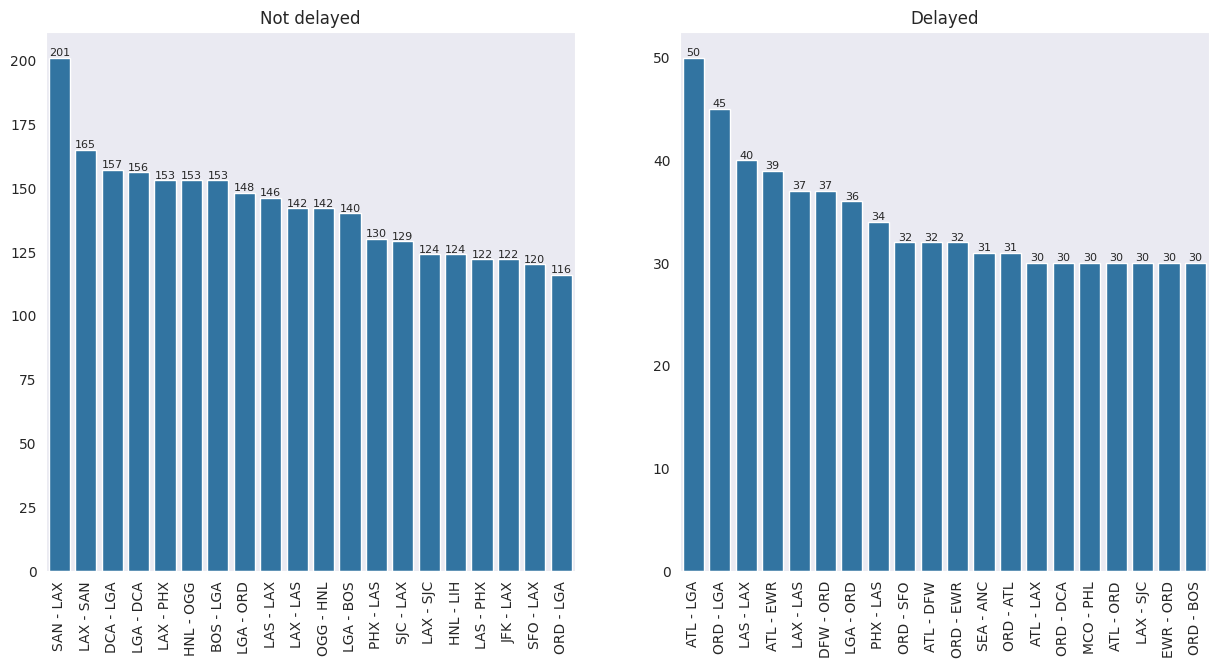

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
plot_routes(0, 'Not delayed', axes[0])
plot_routes(1, 'Delayed', axes[1])
plt.show()

Видим, что пересечений рейсов для топ-20 нет, то есть если по маршруту много незадержанных рейсов, то мало задержанных и наоборот

Теперь посчитаем процент задержанных рейсов для тренировочной выборки, рассчитывая кумулятивную статистику для интервалов ([0-0.1), [0.1-0.2), ..., [0.9, 1])

<ipython-input-38-08eb9676759b>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentage_delayed = dict(train.groupby('Route').apply(lambda x: x[x['dep_delayed_15min'] == 1].shape[0] / x.shape[0]).sort_values(ascending=False))


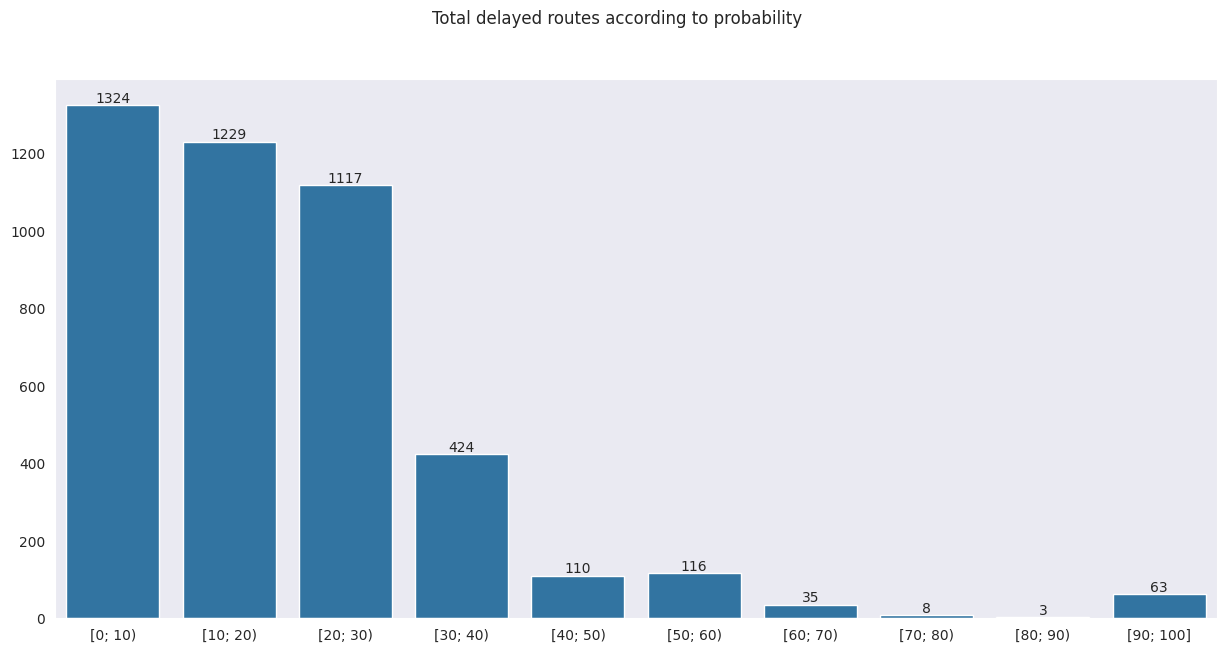

In [ ]:
percentage_delayed = dict(train.groupby('Route').apply(lambda x: x[x['dep_delayed_15min'] == 1].shape[0] / x.shape[0]).sort_values(ascending=False))

intervals = {i * 10: 0 for i in range(10)}
for route, percent in percentage_delayed.items():
    key = int(percent * 100) // 10 * 10
    if key == 100:
        key -= 10
    intervals[key] += 1

_, ax = plt.subplots(figsize=(15, 7))

boxes, total = list(zip(*intervals.items()))
boxes = [f'[{box}; {box + 10}' + (')' if box < 90 else ']') for box in boxes]
sns.barplot(x=boxes, y=total, ax=ax)
ax.bar_label(ax.containers[0], fontsize=10)

plt.suptitle('Total delayed routes according to probability')
plt.show()

Видим, что в данном случае распределение напоминает экспоненциальное, и нечасто задерживаемых рейсов на порядок больше, чем часто задерживаемых. Это знание может пригодиться модели, поэтому я добавлю процент задержанных рейсов в качестве дополнительного признака

In [ ]:
train.insert(train.shape[1] - 1, 'PercentageOfDelayedRoutes', train.apply(lambda x: percentage_delayed[x['Route']], axis=1))

In [ ]:
train.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-8       c-21       c-7     1934            AA    ATL          5  DFW   
1   c-4       c-20       c-3     1548            US    PIT          4  MCO   
2   c-9        c-2       c-5     1422            XE    RDU          4  CLE   
3  c-11       c-25       c-6     1015            OO    DEN          5  MEM   
4  c-10        c-7       c-6     1828            WN    MDW          4  OMA   

   DestCat  Distance      Route  PercentageOfDelayedRoutes  dep_delayed_15min  
0        5       732  ATL - DFW                   0.235294                  0  
1        5       834  PIT - MCO                   0.166667                  0  
2        4       416  RDU - CLE                   0.090909                  0  
3        4       872  DEN - MEM                   0.142857                  0  
4        3       423  MDW - OMA                   0.466667                  1

Видим, что около 3.75% тестовых маршрутов нет в тренировочных данных, поэтому для них зачение признака будет средним процентом задержанных рейсов для тренировочной выборки

In [ ]:
test[~test['Route'].isin(percentage_delayed)].shape[0] / test.shape[0] * 100

3.749

In [ ]:
mean_percentage = train['PercentageOfDelayedRoutes'].mean()
test.insert(test.shape[1], 'PercentageOfDelayedRoutes', test.apply(lambda x: percentage_delayed.get(x['Route'], mean_percentage), axis=1))

In [ ]:
test.head()

Month DayOfMonth DayOfWeek  DepTime UniqueCarrier Origin  OriginCat Dest  \
0   c-7       c-25       c-3      615            YV    MRY          2  PHX   
1   c-4       c-17       c-2      739            WN    LAS          5  HOU   
2  c-12        c-2       c-7      651            MQ    GSP          3  ORD   
3   c-3       c-25       c-7     1614            WN    BWI          4  MHT   
4   c-6        c-6       c-3     1505            UA    ORD          5  STL   

   DestCat  Distance      Route  PercentageOfDelayedRoutes  
0        5       598  MRY - PHX                   0.250000  
1        4      1235  LAS - HOU                   0.285714  
2        5       577  GSP - ORD                   0.117647  
3        3       377  BWI - MHT                   0.166667  
4        4       258  ORD - STL                   0.262295

Теперь найдём категориальные и численные столбцы

In [ ]:
categorical_columns = [column for column in train.columns if train[column].dtypes == 'O']
numerical_columns = [column for column in train.columns if train[column].dtypes != 'O']

Посчитаем корреляцию Пирсона по численным столбцам

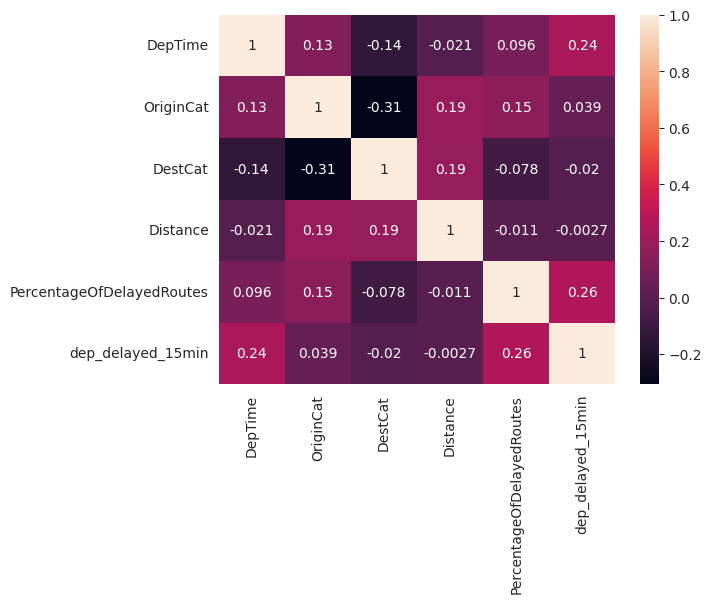

In [ ]:
sns.heatmap(train[numerical_columns].corr(), annot=True)
plt.show()

Только время отправления и процент задержанных рейсов имеют хоть сколько-нибудь значимую корреляцию с целевой переменной, самая же большая корреляция по модулю между OriginCat и DestCat

При подсчёте используется коэффициент неопределённости Тейла (так как категориальная переменная сравнивается с категориальной)

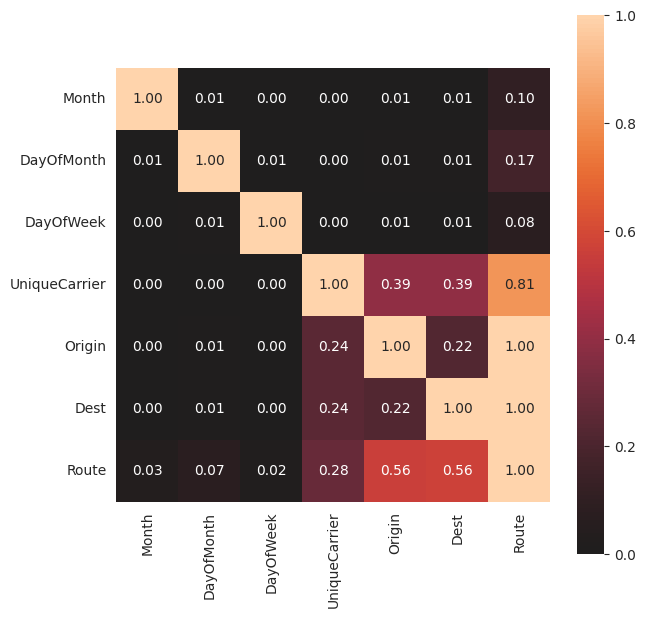

In [ ]:
categorical_correlation_matrix = associations(dataset=train[categorical_columns], compute_only=False, nom_nom_assoc='theil', figsize=(7, 7))

Видим следующее:

1) Высокая корреляция между авиаперевозчиком и рейсом, что логично, ведь у перевозчика могут быть регулярные рейсы между конкретными аэропортами

2) Довольно высокая корреляция между признаком маршрута и признаками аэропортов отправки и прибытия, что тожке логично, ведь первый признак - конкатенация последних

### Обучение моделей

В данной работе я попробую 4 модели градиентного бустинга - Catboost, XGBoost и LightGBM. Для каждой модели будут подобраны оптимальные гиперапарамеры с помощью фреймворка optuna на кросс-валидации таким образом, чтобы значение метрики roc_auc на валидационной выборке было как можно больше



Определим X_train, y_train и X_test

In [ ]:
X_train, y_train = train.drop(columns='dep_delayed_15min'), train['dep_delayed_15min']
X_test = test

Удалим из численных столбцов целевую переменную

In [ ]:
numerical_columns.remove('dep_delayed_15min')

Поменям тип у категориальных переменных на category (чтобы XGBoost и LightGBM могли обрабатывать категориальные признаки)

In [ ]:
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

Посчитаем веса для классов (так как датасет несбалансирован)

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

Создадим функцию, в которой будем подбирать оптимальные гиперпараметры с помощью OptunaSearchCV

In [ ]:
def search(estimator, distributions, n_trials, X_train=X_train, y_train=y_train):
    optuna_search = OptunaSearchCV(
        estimator=estimator,
        param_distributions=distributions,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_trials=n_trials, scoring='roc_auc',
        verbose=1
    )
    optuna_search.fit(X_train, y_train)
    return optuna_search.best_estimator_

Создадим синтетический пример, который затем будет использоваться при анализе интерпретируемости моделей с помощью SHAP и LIME

In [ ]:
synthetic = pd.DataFrame({
    'Month': [11],
    'DayOfMonth': 21,
    'DayOfWeek': 1,
    'DepTime': 632,
    'UniqueCarrier': 7,
    'Origin': 19,
    'OriginCat': 2,
    'Dest': 164,
    'DestCat': 2,
    'Distance': 303,
    'Route': 221,
    'PercentageOfDelayedRoutes': 0.233333
})

Закодируем категориальные колонки label-кодировщиком, чтобы корректно использовать LIME

In [ ]:
for column in 'DayOfMonth', 'DayOfWeek', 'Month':
    X_train[column] = X_train.apply(lambda x: x[column][2:].zfill(2), axis=1)
    X_test[column] = X_test.apply(lambda x: x[column][2:].zfill(2), axis=1)

In [ ]:
categorical_features = []
categorical_names = {}
for column in categorical_columns:
    label_encoder = LabelEncoder()
    all_values = sorted(list(set(X_train[column].values) | set(X_test[column].values)))
    label_encoder.fit(all_values)
    X_train[column] = label_encoder.transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])
    index = X_train.columns.get_loc(column)
    categorical_features.append(index)
    categorical_names[index] = sorted(X_train[column].unique())

Создадим explainer LIME, он будет один на все 3 модели

In [ ]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    class_names=['0', '1'], mode='classification',
    discretize_continuous=True
)

#### Catboost

In [ ]:
%%time
cb = CatBoostClassifier(
    loss_function='Logloss',
    class_weights=class_weights,
    cat_features=categorical_columns,
    verbose=0
)

cb_param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500, log=True),
    'depth': optuna.distributions.IntDistribution(2, 10),
    'learning_rate': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'l2_leaf_reg': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'min_data_in_leaf': optuna.distributions.IntDistribution(1, 50),
}

best_cb = search(cb, cb_param_distributions, 30)

<ipython-input-51-8ea25f5c4bc6>:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-05-21 20:22:35,156] A new study created in memory with name: no-name-c39b1b9f-9a0a-4b01-9e5f-c8d4167c6a9b
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 100000 samples...
[I 2025-05-21 20:30:40,604] Trial 0 finished with value: 0.8309133956343052 and parameters: {'n_estimators': 396, 'depth': 8, 'learning_rate': 0.07950364316768636, 'l2_leaf_reg': 0.8370331199614467, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.8309133956343052.
[I 2025-05-21 20:30:54,167] Trial 1 finished with value: 0.7900255388955106 and parameters: {'n_estimators': 105, 'depth': 2, 'learning_rate': 0.16183479693999844, 'l2_leaf_reg': 0.016265541808716852, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.8309133956343052.
[I 2025-05-21 20:34:50,609] Trial 2 finished with valu

CPU times: user 2h 46min 14s, sys: 9min 18s, total: 2h 55min 33s
Wall time: 1h 42min 44s


Создадим переменную explainer и посчитаем значения SHAP сначала для всей выборки, а потом для синтетического примера

In [ ]:
explainer_cb = shap.TreeExplainer(best_cb)
shap_values_cb = explainer_cb.shap_values(X_train)
shap_single_value_cb = explainer_cb.shap_values(synthetic)

Теперь посмотрим на то, какие признаки влияют на получившийся ответ у синтетического примера

In [ ]:
shap.initjs()
shap.force_plot(explainer_cb.expected_value, shap_single_value_cb[0], synthetic.iloc[0, :])

Как видим, время отправки сильнее всего влияет на то, чтобы пример был отнесён к нулевому классу, а процент отменённых рейсов - сильнее всего на то, чтобы пример был отнесён к первому классу

Далее взглянем на то, как влияют значения признаков  на предсказания для первых 100 примеров из обучающей выборки

In [ ]:
shap.initjs()
shap.force_plot(explainer_cb.expected_value, shap_values_cb[0:100, :], X_train.iloc[0:100, :])

Теперь помотрим на важности признаков по значениям SHAP

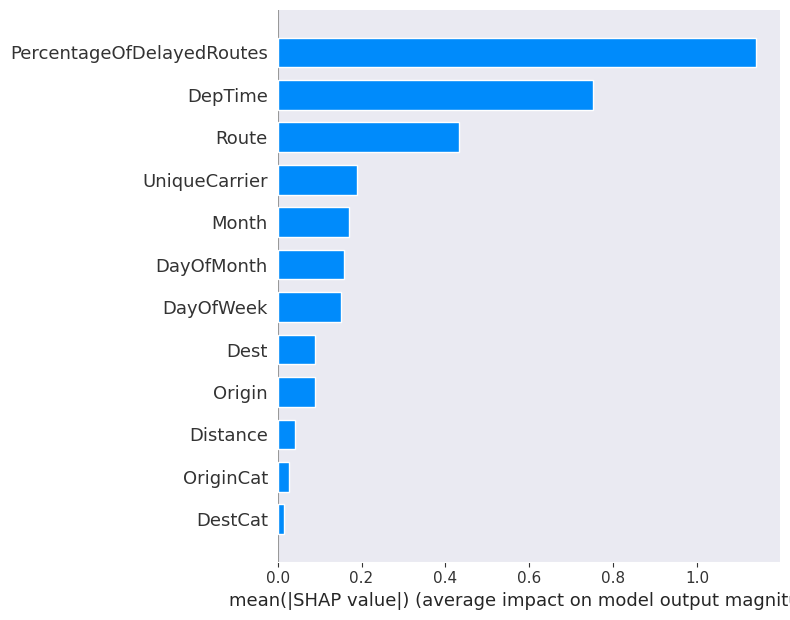

In [ ]:
shap.summary_plot(shap_values_cb, X_train, plot_type='bar')

Видим, что сильнее всего влияют на получение ответа признаки процента отменённых рейсов, времени отпраки и маршрута

Очень слабое влияние у категориальных признаков пунктов отправления и прибытия

Затем посмотрим на важность влияния каждого признака на формирование ответов из всей обучающей выборки

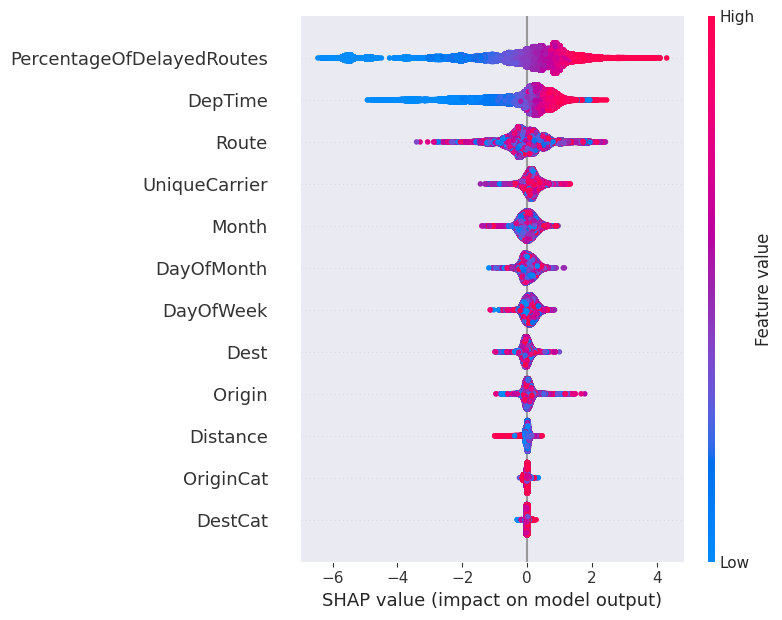

In [ ]:
shap.summary_plot(shap_values_cb, X_train)

Для признаков процента отменённых рейсов и времени отправления можно с уверенностью сказать, что меньшее значение SHAP ведёт к меньшей вероятности отнесения к классу задержанных рейсов, у признака дальности полёта наоборот, меньшим значениям SHAP сответствуют высокие вероятности задержки рейса

Ну и посмотрим на то, как LIME справляется в внутренней интерпретацией результата для синтетического примера

In [ ]:
categorical_features

[0, 1, 2, 4, 5, 7, 10]

In [ ]:
def predict_fn(x):
    x = pd.DataFrame(x, columns=X_train.columns)
    for column in categorical_columns:
        x[column] = x[column].astype(int)
    return best_cb.predict_proba(x)


explanation_cb = explainer_lime.explain_instance(data_row=synthetic.iloc[0, :], predict_fn=predict_fn, num_features=X_train.shape[1])
explanation_cb.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Видим, что процент отнесения объекта к 1 классу - 0.11

Сильнее всего заставляет делать предсказание 0 класса признак времени отправки, а предсказание в сторону 1 класса - процент отменённых рейсов

#### XGBoost

Найдём отношение числа образцов 0 класса к числу образцов 1 класса, чтобы позже передать это значение в конструктор класса XGBoost

In [ ]:
scale_post_weight = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]

In [ ]:
%%time
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_post_weight,
    eval_metric='auc',
    use_label_encoder=False,
    enable_categorical=True,
    verbosity=0
)

xgb_param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500, log=True),
    'depth': optuna.distributions.IntDistribution(2, 10),
    'learning_rate': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'reg_alpha': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'reg_lambda': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'max_leaves': optuna.distributions.IntDistribution(5, 500),
}

best_xgb = search(xgb, xgb_param_distributions, 30)

<ipython-input-51-8ea25f5c4bc6>:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-05-21 22:10:43,969] A new study created in memory with name: no-name-43485c9f-6130-4408-9da4-f0cdc7c54f6d
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 100000 samples...
[I 2025-05-21 22:10:54,127] Trial 0 finished with value: 0.7714703152830138 and parameters: {'n_estimators': 55, 'depth': 4, 'learning_rate': 0.3561393249678406, 'reg_alpha': 0.010818009003883997, 'reg_lambda': 0.2183166768582951, 'max_leaves': 282}. Best is trial 0 with value: 0.7714703152830138.
[I 2025-05-21 22:11:07,392] Trial 1 finished with value: 0.7734556741366501 and parameters: {'n_estimators': 121, 'depth': 6, 'learning_rate': 0.228934591417934, 'reg_alpha': 0.9218166662493328, 'reg_lambda': 0.10719300717725884, 'max_leaves': 150}. Best is trial 1 with value: 0.7734556741366501.
[I 

CPU times: user 12min 28s, sys: 3.52 s, total: 12min 31s
Wall time: 7min 16s


Создадим переменную explainer и посчитаем значения SHAP сначала для всей выборки, а потом для синтетического примера

In [ ]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)
shap_single_value_xgb = explainer_xgb.shap_values(synthetic)

Теперь посмотрим на то, какие признаки влияют на получившийся ответ у синтетического примера

In [ ]:
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_single_value_xgb[0], synthetic.iloc[0, :])

Видим, что время отправки сильнее всего влияет на то, чтобы отнести пример к 0 классу, а признак месяца - к 1

Далее взглянем на то, как влияют значения признаков  на предсказания для первых 100 примеров из обучающей выборки

In [ ]:
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0:100, :], X_train.iloc[0:100, :])

Теперь помотрим на важности признаков по значениям SHAP

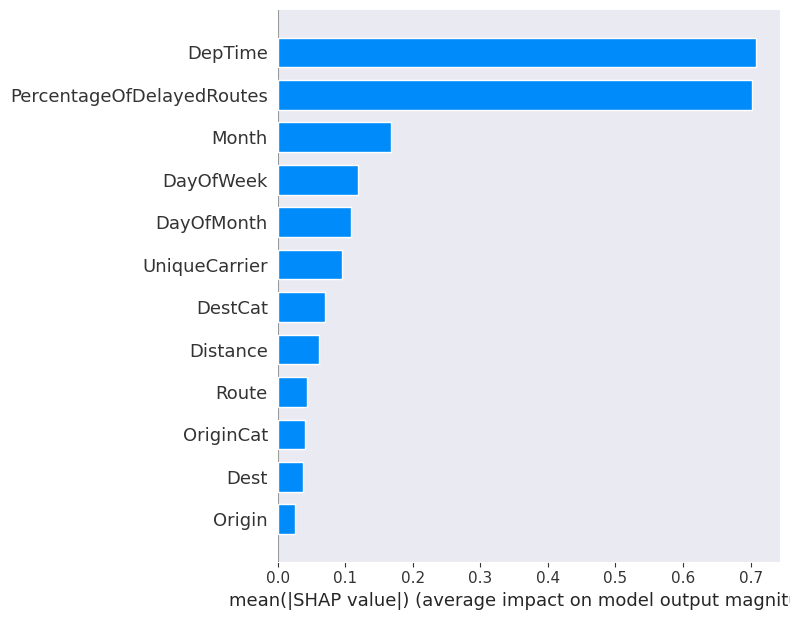

In [ ]:
shap.summary_plot(shap_values_xgb, X_train, plot_type='bar')

Здесь маловажен признак маршрута, но очень сильное вляние оказывает время вылета, процент задержанных рейсов и признак месяца

Затем посмотрим на важность влияния каждого признака на формирование ответов из всей обучающей выборки

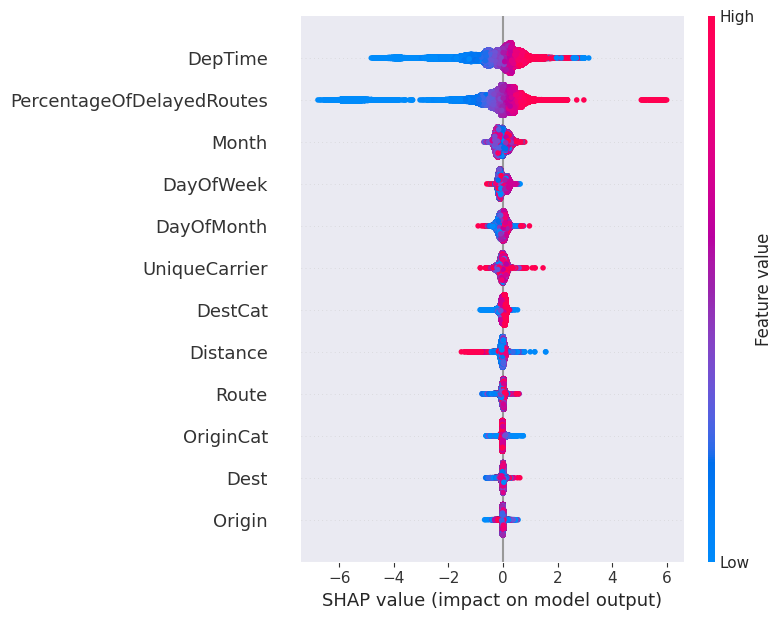

In [ ]:
shap.summary_plot(shap_values_xgb, X_train)

Для признаков процента отменённых рейсов и времени отправления можно с уверенностью сказать, что меньшее значение SHAP ведёт к меньшей вероятности отнесения к классу задержанных рейсов, у признака дальности полёта наоборот, меньшим значениям SHAP сответствуют высокие вероятности задержки рейса

Ну и посмотрим на то, как LIME справляется в внутренней интерпретацией результата для синтетического примера

In [ ]:
explanation_xgb = explainer_lime.explain_instance(data_row=synthetic.iloc[0, :], predict_fn=best_xgb.predict_proba, num_features=X_train.shape[1])
explanation_xgb.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Видим, что процент отнесения объекта к 1 классу - 0.21

Сильнее всего заставляет делать предсказание 0 класса признак времени отправки, а предсказание в сторону 1 класса - процент отменённых рейсов

#### LightGBM

In [ ]:
%%time
lgbm = LGBMClassifier(
    objective='binary',
    class_weight=class_weights,
    metric='auc',
    verbose=-1
)

lgbm_param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500, log=True),
    'max_depth': optuna.distributions.IntDistribution(2, 10),
    'learning_rate': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'reg_alpha': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'reg_lambda': optuna.distributions.FloatDistribution(1e-2, 1, log=True),
    'num_leaves': optuna.distributions.IntDistribution(5, 500),
    'min_child_samples': optuna.distributions.IntDistribution(1, 50)
}

best_lgbm = search(lgbm, lgbm_param_distributions, 30)

<ipython-input-51-8ea25f5c4bc6>:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-05-21 22:25:07,392] A new study created in memory with name: no-name-9f8c5efe-23e6-410d-a83c-f9d2871884ad
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 100000 samples...
[I 2025-05-21 22:25:29,740] Trial 0 finished with value: 0.7693904671780418 and parameters: {'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.013962183314213452, 'reg_alpha': 0.023039708593892365, 'reg_lambda': 0.010655477365668794, 'num_leaves': 223, 'min_child_samples': 17}. Best is trial 0 with value: 0.7693904671780418.
[I 2025-05-21 22:25:33,698] Trial 1 finished with value: 0.7539070193013865 and parameters: {'n_estimators': 67, 'max_depth': 7, 'learning_rate': 0.022243008536085154, 'reg_alpha': 0.6409866163771387, 'reg_lambda': 0.01576884469469688, 'num_leaves': 11, 'min_child_sa

CPU times: user 8min 6s, sys: 4.38 s, total: 8min 10s
Wall time: 8min 12s


Создадим переменную explainer и посчитаем значения SHAP сначала для всей выборки, а потом для синтетического примера

In [ ]:
explainer_lgbm = shap.TreeExplainer(best_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_train)
shap_single_value_lgbm = explainer_lgbm.shap_values(synthetic)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Теперь посмотрим на то, какие признаки влияют на получившийся ответ у синтетического примера

In [ ]:
shap.initjs()
shap.force_plot(explainer_lgbm.expected_value, shap_single_value_lgbm[0], synthetic.iloc[0, :])

Видим, что время отправки сильнее всего влияет на то, чтобы отнести пример к 0 классу, а процент отменённых рейсов - к 1

Далее взглянем на то, как влияют значения признаков  на предсказания для первых 100 примеров из обучающей выборки

In [ ]:
shap.initjs()
shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm[0:100, :], X_train.iloc[0:100, :])

Теперь помотрим на важности признаков по значениям SHAP

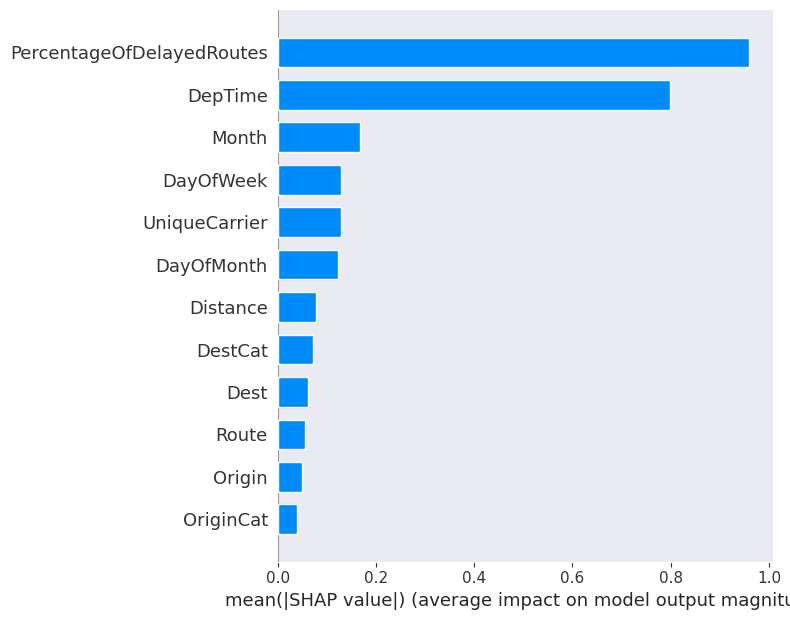

In [ ]:
shap.summary_plot(shap_values_lgbm, X_train, plot_type='bar')

Здесь, как и у CatBoost, важен процент отменённых рейсов, однако куда менее важен признак маршрута, да и категориальный признак пункта назначения имеет повышенную важность

Затем посмотрим на важность влияния каждого признака на формирование ответов из всей обучающей выборки

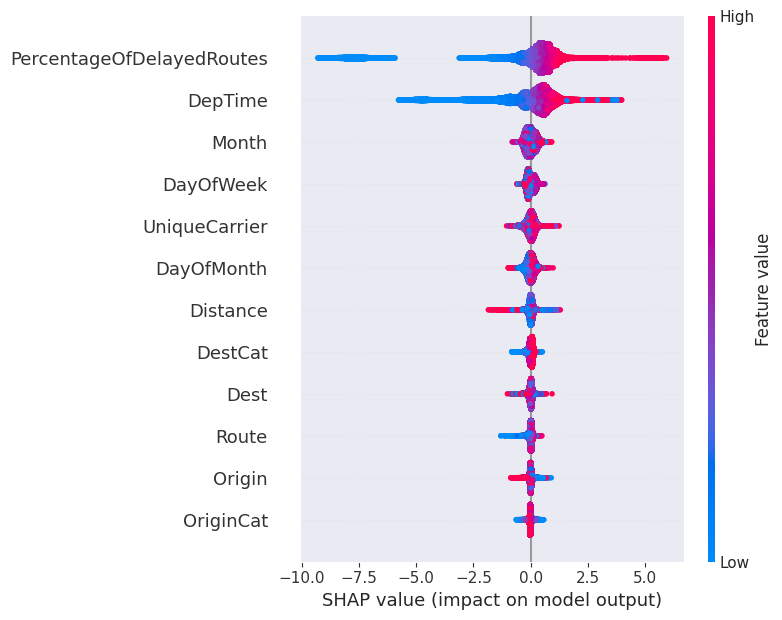

In [ ]:
shap.summary_plot(shap_values_lgbm, X_train)

Для признаков процента отменённых рейсов и времени отправления можно с уверенностью сказать, что меньшее значение SHAP ведёт к меньшей вероятности отнесения к классу задержанных рейсов, у признака дальности полёта наоборот, меньшим значениям SHAP сответствуют высокие вероятности задержки рейса

Ну и посмотрим на то, как LIME справляется в внутренней интерпретацией результата для синтетического примера

In [ ]:
explanation_lgbm = explainer_lime.explain_instance(data_row=synthetic.iloc[0, :], predict_fn=best_lgbm.predict_proba, num_features=X_train.shape[1])
explanation_lgbm.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Видим, что процент отнесения объекта к 1 классу - 0.31

Сильнее всего заставляет делать предсказание 0 класса признак времени отправки, а предсказание в сторону 1 класса - процент отменённых рейсов

### Формирование ответа

Для начала посчитаем accuracy для каждого классификатора на всей тренировочной выборке

In [ ]:
accuracies = {
    'catboost': accuracy_score(y_train, best_cb.predict(X_train)),
    'XGBoost': accuracy_score(y_train, best_xgb.predict(X_train)),
    'LightGBM': accuracy_score(y_train, best_lgbm.predict(X_train)),
}

In [ ]:
accuracies

{'catboost': 0.78379, 'XGBoost': 0.71794, 'LightGBM': 0.74643}

Теперь нормируем каждое значение на сумму метрик accuracy

In [ ]:
coefs = {}
denominator = sum(accuracies.values())
for key, value in accuracies.items():
    coefs[key] = value / denominator

Предскажем вероятности каждой моделью

In [ ]:
sample_submission = pd.DataFrame({
    'catboost': best_cb.predict_proba(X_test)[:, 1],
    'XGBoost': best_xgb.predict_proba(X_test)[:, 1],
    'LightGBM': best_lgbm.predict_proba(X_test)[:, 1]
}, index=X_test.index)
sample_submission.index.name = 'id'

In [ ]:
sample_submission.head()

catboost   XGBoost  LightGBM
id                              
0   0.062419  0.388031  0.389114
1   0.159195  0.211654  0.206690
2   0.084693  0.258497  0.191366
3   0.638792  0.521828  0.538405
4   0.616455  0.530037  0.514056

Теперь умножим предсказние каждой модели на свой коэффициент и сложим, так и получается финальная вероятность

In [ ]:
submission = pd.DataFrame((sample_submission * coefs.values()).sum(axis=1), columns=['dep_delayed_15min'])
submission.head()

dep_delayed_15min
id                   
0            0.274870
1            0.191717
2            0.175614
3            0.568110
4            0.554859

Сохраним предсказанные вероятности

In [ ]:
submission.to_csv('submission.csv')